# Make ACTN2 Affimer PERPL analysis plots

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import modelling_general
# import plotting
from zdisk_modelling import *
# from zdisk_plots import plot_distance_hist # FUCKEN HATES IMPORTING ANYTHING FROM THIS MODULE, ALWAYS HANGS

## Set average estimated localisation precision for Affimer and PALM data.
This is the mean after filtering for localisation precision < 5 nm.

In [2]:
af647_precision = 8.1 # Mean value after filtering for precision < 5 nm # BUGGY CELL

## Set standard maximum distance over which to plot distances and fit models.

In [3]:
fitlength = 100

## Choose Affimer relative position data and combine files if necessary
### Insert paths to the Affimer relative position data here:

In [4]:
actn_affimer_relpos_path = r"/Users/sianculley/Code/PERPL-Python3/data/PERPL_relative_positions/0nm_0pc_filter_65-141nm_10nm_uncertainty/filter_60_2D_bin1_2024-01-05_18-47-10/0nm_0pc_filter_65-141nm_10nm_uncertainty_PERPL-relpos_60.0filter.csv"
relpos = pd.read_csv(actn_affimer_relpos_path)
# need to rename columns 3 and 4 to axial and transverse
relpos = relpos.rename(columns={" ": "axial", "xy_separation": "transverse"})
print(relpos)

       xx_separation  yy_separation  axial  transverse
0            0.10062        0.19558    0.0    0.219945
1            0.27771       -0.03546    0.0    0.279965
2            0.33143        0.10600    0.0    0.347968
3            0.13413       -0.44378    0.0    0.463607
4            0.42574        0.38593    0.0    0.574627
...              ...            ...    ...         ...
13418       56.97484       58.82318    0.0   81.891995
13419       59.94875       55.93298    0.0   81.989944
13420       59.16683      -58.17960    0.0   82.979393
13421       59.39962      -58.57249    0.0   83.420929
13422       59.24363      -59.81104    0.0   84.185321

[13423 rows x 4 columns]


### Select desired datasets to combine here:
These contain all data attributes, including the relative positions in both directions for each pair of localisations. We will filter e.g. for cell-axial data later.

### Data attributes and number of data points:

In [5]:
relpos.iloc[0, :] # This shows the first relative position.

xx_separation    0.100620
yy_separation    0.195580
axial            0.000000
transverse       0.219945
Name: 0, dtype: float64

In [6]:
len(relpos) # This shows how many relative positions.

13423

## Get the axial (X) distances, without duplicates
The YZ-distance limit for pairs of localisations to include can be set here.

In [8]:
# This is the YZ-distance limit for X-distances to include:
transverse_limit = 60.

transverse_distances = get_transverse_separations(relpos, max_distance=100., axial_limit=10.)
transverse_distances = remove_duplicates(transverse_distances)
print(transverse_distances)

[ 0.21994527  0.34796817  0.57462728 ... 81.89199533 82.97939279
 84.18532058]


## Get the 1-nm bin histogram data
Up to distance = fitlength

In [9]:
# PASTE FUNCTION OUT OF BUGGY MODULE
def plot_distance_hist(distances, fitlength, color='gray'):
    """Plot histogram of experimental distances, with 1 nm bins.

    Args:
        distances (numpy array-like):
            Set of distances (nm) to plot.
        fitlength (float):
            The distance upto which the histogram will be calculated.
        color (string):
            Colour for the matplotlib histogram.
    Returns:
        hist_values (numpy array):
            Histogram bin values.
        bin_edges (numpy array):
            Histogram bin edge positions. 
    """
    # Histogram figure with 1-nm bins
    histfig = plt.figure()
    histaxes = histfig.add_subplot(111)
    hist_values, bin_edges = histaxes.hist(distances,
                                           bins=np.arange(fitlength + 1),
                                           color=color, alpha=0.5
                                           )[0:2] # 2 not required
    histaxes.set_xlim([0, fitlength])
    # histaxes.set_ylim([0, 82])
    histaxes.set_ylim(bottom=0)
    histaxes.set_title('Histogram')
    histaxes.set_xlabel(r'$\Delta$X (nm) ($\Delta$YZ < 10 nm)')
    histaxes.set_ylabel('Counts')

    return hist_values, bin_edges

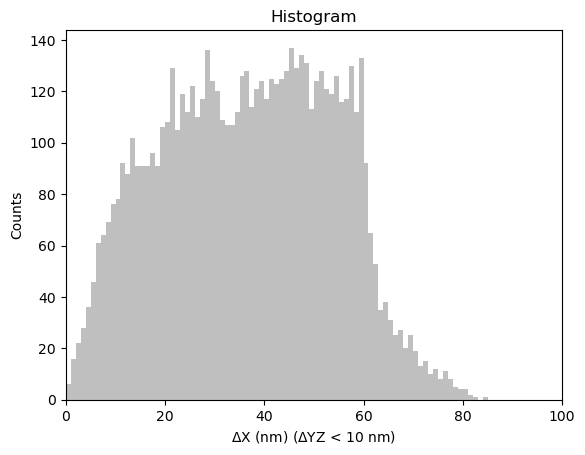

In [10]:
hist_values, bin_edges = plot_distance_hist(
    transverse_distances,
    fitlength
    )
bin_centres = (bin_edges[0:(len(bin_edges) - 1)]
               + bin_edges[1:]
               ) / 2

## Get the KDE data
Estimate every 1 nm, with kernel size based on localisation precision estimate.

In [ ]:
kde_x_values, kde = zdisk_plots.plot_distance_kde(
    axial_distances,
    af647_precision,
    100.
    )

## Calculate the axial RPD with smoothing for Churchman 1D function

In [ ]:
calculation_points = np.arange(fitlength + 1.)
axial_rpd = plotting.estimate_rpd_churchman_1d(
    input_distances=axial_distances,
    calculation_points=calculation_points,
    combined_precision=(np.sqrt(2) * af647_precision)
)
plt.plot(calculation_points, axial_rpd)

## Choose axial model:

In [ ]:
axial_model_with_info = zdisk_modelling.set_up_model_4_peaks_fixed_ratio_with_fit_settings()


## Fit model to histogram bin values, at bin centres

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    bin_centres,
    hist_values,
    axial_model_with_info.model_rpd,
    axial_model_with_info.initial_params,
    axial_model_with_info.param_bounds,
    )
print('')
print('Initial parameter guesses:')
print(axial_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(axial_model_with_info.param_bounds)

## Plot fitted model over histogram data

In [ ]:
fig, axes = zdisk_plots.plot_distance_hist_and_fit(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info
)

## Plot fitted model over histogram data, with confidence intervals on the model
### NOTE: IT TAKES A WHILE TO CALCULATE THE CONFIDENCE INTERVALS
### Skip this if you don't need it right now.

In [ ]:
zdisk_plots.plot_distance_hist_and_fit(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info,
    plot_95ci=True
)

## Akaike weights for the models
Typed in AICc values for the different models here, to obtain relative likelihood, summing to one:

In [ ]:
from modelstats import akaike_weights
weights = akaike_weights([
    364.35,
    364.51,
    366.38,
    370.28,
    374.67
])
print(weights)

## Plot model components for best model (4 peaks with fixed peak ratio)

In [ ]:
zdisk_plots.plot_model_components_4peaks_fixed_peak_ratio(
    fitlength,
    *params_optimised)

# Transverse distances

## Get the transverse (YZ) distances, without duplicates
The X-distance limit for pairs of localisations to include can be set here.

In [ ]:
# This is the YZ-distance limit for X-distances to include:
axial_limit = 10.
print(relpos.shape)

trans_distances = zdisk_modelling.get_transverse_separations(
    relpos,
    max_distance=relpos.transverse.max(),
    axial_limit=axial_limit
    )
trans_distances = zdisk_modelling.remove_duplicates(trans_distances)

## Choose analysis lengthscale for transverse distance

In [ ]:
fitlength = 50.

In [ ]:
hist_1nm_bins = plt.hist(trans_distances, bins=np.arange(fitlength + 1.))

## Estimate RPD using Churchman's function

In [ ]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision= np.sqrt(2) * af647_precision
transverse_rpd = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)
plt.plot(calculation_points, transverse_rpd)

## Normalise for increasing search circle with increasing distance

In [ ]:
normalised_transverse_rpd = transverse_rpd[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd)

### 1 nm-bin  histogram result for comparison

In [ ]:
plt.plot(hist_1nm_bins[1][0:-1] + 0.5, hist_1nm_bins[0]/(hist_1nm_bins[1][0:-1] + 0.5))

### Optional save/load to save time

In [ ]:
np.save('normalised_transverse_rpd_smoothed_Churchman-4p4', normalised_transverse_rpd)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

## Set up an RPD model and fit
I've tried a few smoothing kernel widths here.

In [ ]:
trans_model_with_info = zdisk_modelling.set_up_model_2d_onepeak_plus_replocs_flat_bg_with_fit_settings()

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

In [ ]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=8.
transverse_rpd_s8 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

In [ ]:
normalised_transverse_rpd_s8 = transverse_rpd_s8[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s8)
np.save('..\data-perpl\ACTN2-Affimer\\normalised_transverse_rpd_smoothed_Churchman-8', normalised_transverse_rpd_s8)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd_s8)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

In [ ]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=5.
transverse_rpd_s5 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

In [ ]:
normalised_transverse_rpd_s5 = transverse_rpd_s5[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s5)
np.save('normalised_transverse_rpd_smoothed_Churchman-5', normalised_transverse_rpd_s5)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [ ]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=6.
transverse_rpd_s6 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

In [ ]:
normalised_transverse_rpd_s6 = transverse_rpd_s6[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s6)
np.save('normalised_transverse_rpd_smoothed_Churchman-6', normalised_transverse_rpd_s6)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd_s8)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

## Set up another model and fit
Tried a few smoothing widths again
### This model fits much better

In [ ]:
trans_model_with_info = zdisk_modelling.set_up_model_2d_twopeaks_flat_bg_with_fit_settings()

In [ ]:
normalised_transverse_rpd_s6 = np.load('./normalised_transverse_rpd_smoothed_Churchman-6.npy')
calculation_points = np.arange(fitlength + 1.)
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [ ]:
normalised_transverse_rpd_s8 = np.load('./normalised_transverse_rpd_smoothed_Churchman-8.npy')
calculation_points = np.arange(fitlength + 1.)
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s5[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s5[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )